In [1]:
import os
import sys
from ultralytics import SAM
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np
from PIL import Image
from ultralytics.data.utils import visualize_image_annotations
# sys.path.append('./poisson-image-editing-master')
# import poisson_image_editing as pie

In [2]:
# Class folders should be organized as follows:
#
# raw/
# └── screwdriver_kaggle/
#    ├── screwdriver/
#    │   ├── images/
#    │   │   ├── 1.jpg
#    │   │   └── ...
#    │   ├── labels/
#    │   │   ├── 1.txt
#    │   │   └── ...
#    │   ├── masks/
#    │   │   ├── 1_mask.png
#    │   │   └── ...  
#    ├── hammer/
#    │   └── .../
#    ├── .../
#    └── classes.txt

# Darknet files should have the following format:
# class_index x_center y_center width height
#
# e.g.
# 0 0.5 0.5 0.2 0.2

# classes.txt should contain the class names, one per line:
# e.g.
# screwdriver
# hammer
# ...

raw_dataset_name = 'kaggle_v0'
cnp_output_name = 'cut_and_paste_root2'
output_dataset_name = 'cut_and_paste_vik_test'
object_classes = ['screwdriver', 'hammer']
class_dirs = [f'/home/data/raw/{raw_dataset_name}/{object_class}/' for object_class in object_classes]
output_dirs = class_dirs
# output_dirs = [f'/home/data/raw/{raw_dataset_name}/{cnp_output_name}/{object_class}/' for object_class in object_classes]
# output_dirs = [f'/home/data/raw/{project_name}/{object_class}/' for object_class in object_classes]


In [3]:
def read_darknet_bboxes(bbox_path, image_width, image_height):
	"""Read bounding boxes from darknet format file and convert to pixel coordinates"""
	bboxes = []
	
	with open(bbox_path, 'r') as f:
		for line in f:
			parts = line.strip().split()
			assert len(parts) == 5, f"Invalid bbox line: {line.strip()}"
			
			# Darknet format: class_id x_center y_center width height (normalized)
			class_id = int(parts[0])
			x_center = float(parts[1])
			y_center = float(parts[2])
			width = float(parts[3])
			height = float(parts[4])
			
			# Convert from normalized coordinates to pixel coordinates
			x_center_px = x_center * image_width
			y_center_px = y_center * image_height
			width_px = width * image_width
			height_px = height * image_height
			
			# Convert to x1, y1, x2, y2 format
			x1 = int(x_center_px - width_px / 2)
			y1 = int(y_center_px - height_px / 2)
			x2 = int(x_center_px + width_px / 2)
			y2 = int(y_center_px + height_px / 2)
			
			# Ensure coordinates are within image bounds
			x1 = max(0, min(x1, image_width - 1))
			y1 = max(0, min(y1, image_height - 1))
			x2 = max(0, min(x2, image_width - 1))
			y2 = max(0, min(y2, image_height - 1))
			
			bboxes.append([x1, y1, x2, y2])

	return bboxes

def segment_images_from_folder_bbox(class_dir, output_dir):
    """
    Segments images in the specified folder using the SAM model with bbox information.
    Assumes class_dir contains two folders: 'images_resized' and 'labels'.
    Each image in 'images_resized' should have a corresponding label file in 'labels' with
    bounding box information in the format: x y w h (where x, y are the
    top-left corner coordinates and w, h are the width and height of the bounding box).
    """
    model = SAM("sam2.1_l.pt")

    for image_path, bbox_path in list(zip(sorted(glob.glob(os.path.join(class_dir, 'images', '*'))), 
                                          sorted(glob.glob(os.path.join(class_dir, 'labels', '*.txt'))))):
        image_dimensions = cv2.imread(image_path).shape
        bboxes = read_darknet_bboxes(bbox_path, image_dimensions[1], image_dimensions[0])
        
        # Predict segmentation using the SAM model with bounding box
        results = model(image_path, bboxes=bboxes)
        # visualize_image_annotations(image_path, bbox_path, output_dir)
        for result in results:
            # Access the masks
            masks = results[0].masks

            # Assuming single class segmentation for simplicity, adjust as needed
            mask = masks[0].data.squeeze().cpu().numpy()  # For multi-class, iterate over masks
            mask = mask.astype(np.uint8) # Convert mask to uint8 if needed)
            mask = cv2.resize(mask, (image_dimensions[1], image_dimensions[0]))
            
            image = cv2.imread(image_path)
            image = cv2.resize(image, (image_dimensions[1], image_dimensions[0]))
            
            # Negate the mask and mask the image
            negative_mask = 1-mask
            negative_image = cv2.bitwise_not(image)
            negative_image = cv2.bitwise_and(negative_image, negative_image, mask=mask)
            masked_image = cv2.bitwise_not(negative_image)
            
            # Uncomment to see the negated masks
            # plt.imshow(negative_mask, cmap='gray')
            # plt.axis('off')
            # plt.show()

            # Uncomment to plot the masked images
            # plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
            # plt.axis('off')
            # plt.show()

            os.mkdir(output_dir) if not os.path.exists(output_dir) else None
            for subdir in ['images', 'masks', 'labels']:
            # Create subdirectories if they do not exist
                subdir_path = os.path.join(output_dir, subdir)
                if not os.path.exists(subdir_path): 
                    os.mkdir(subdir_path)
                    
            cv2.imwrite(os.path.join(output_dir, 'masks', os.path.basename(image_path).split('.')[0] + '_mask.png'), negative_mask*255)


## Segment w SAM2

In [ ]:
def resize_images(input_dir, output_dir, size=(640//3, 480//3)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for img_file in glob.glob(os.path.join(input_dir, '*.jpg')):
        img = Image.open(img_file)
        img = img.resize(size, Image.LANCZOS)
        img.save(os.path.join(output_dir, os.path.basename(img_file)))

In [ ]:
# for class_dir in class_dirs:
#     resize_images(os.path.join(class_dir, 'images'), os.path.join(class_dir, 'images_resized'))

In [ ]:
# if not os.path.exists(f'/home/data/raw/{raw_dataset_name}/{cnp_output_name}/'):
#     os.mkdir(f'/home/data/raw/{raw_dataset_name}/{cnp_output_name}')

# os.system(f"cp /home/data/raw/{raw_dataset_name}/classes.txt /home/data/raw/{raw_dataset_name}/{cnp_output_name}/")

for class_dir, output_dir in list(zip(class_dirs, output_dirs)):
	segment_images_from_folder_bbox(class_dir, output_dir)

## Test stuff

In [ ]:
print(f'python Cut-and-Paste/dataset_generator.py --scale --rotation --num 1 /home/data/raw/{raw_dataset_name}/ /home/data/processed/{raw_dataset_name}/{output_dataset_name}')

In [79]:
do_profile = True
profile_addon = "-m cProfile -o results.prof " if do_profile else ""

In [81]:
os.system(f'rm -rf /home/data/processed/{raw_dataset_name}/{output_dataset_name}')
os.system(f'python {profile_addon} Cut-and-Paste/dataset_generator.py --scale --rotation --num 1 /home/data/raw/{raw_dataset_name}/ /home/data/processed/{raw_dataset_name}/{output_dataset_name}')
os.system("""python -c "import pstats; p = pstats.Stats('results.prof'); p.sort_stats('cumulative').print_stats()" > output.txt""")

Generating dataset with scale=True, rotation=True, dont_occlude_much=False, add_distractors=False
Number of background images : 8128
List of distractor files collected: []
Chosen objects: [('/home/data/raw/kaggle_v0/screwdriver/images/afeda6b8-06f9333e-d08c-48af-bd5a-7fd542e70e88.jpg', 'screwdriver'), ('/home/data/raw/kaggle_v0/hammer/images/19d4ce5e-9637bfc9-b7f8-4732-b6c3-fdf0bcf11915.jpg', 'hammer')]
Chosen background file: /home/data/raw/backgrounds/indoorCVPR_09_images/243088.jpg
Working on /home/data/processed/kaggle_v0/cut_and_paste_vik_test/images/1_none.jpg
Creating a new image now...
	Starting a new attempt to synthesize an image...
	Starting new object...
		Rotating object...
		Scaling object...
		Starting an object placement attempt...
	Starting new object...
		Rotating object...
		Scaling object...
		Starting an object placement attempt...
			Trim mask parameters received: (1920, 2560, 3) (456, 165, 3) (456, 165) (919, 713)
			Trim mask parameters received: (1920, 2560, 3)

0

# Try cv2 Seamless Clone

In [24]:
# bg_path = '/home/data/raw/backgrounds/indoorCVPR_09_images/dining057.jpg'
bg_path = '/home/data/raw/backgrounds/indoorCVPR_09_images/arton447_ba6a0.jpg'
# img_path = '/home/data/raw/kaggle_v0/hammer/images/a7cc2f51-40c3ae9f-1bda-4ace-896e-971d9adddd0e.jpg'
img_path ='/home/data/raw/kaggle_v0/screwdriver/images/82d8c17f-43df566b-cdbf-4c7a-b5bb-1f1cb7544c43.jpg'
mask_path = img_path.replace('.jpg', '_mask.png').replace('.jpeg', '_mask.png').replace('/images','/masks')
# label_path = img_path.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('/images','/labels')

In [45]:
dst = cv2.imread(bg_path)     # Background image (3‑channel BGR)
src = cv2.imread(img_path)     # Foreground image (3‑channel BGR)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Single‑channel mask: 255 = foreground

In [52]:
dst = Image.fromarray(dst)
src = Image.fromarray(src)
mask = Image.fromarray(mask)

dst = dst.resize((640*4, 480*4), Image.LANCZOS)
new_size = (319, 593)
src = src.resize(new_size, Image.LANCZOS)
mask = mask.resize(new_size, Image.NEAREST)

dst = np.array(dst)
src = np.array(src)
mask = 255-np.array(mask)

In [53]:
# given an array of images, show them in a grid (along with their title headings describing their shapes and min max values)
def show_images(img_array, figsize=(3,2)):
	n = len(img_array)
	cols = n
	fig, axes = plt.subplots(1, cols, figsize=(figsize[0]*n, figsize[1]))
	if not hasattr(axes, '__iter__'):
		axes = [axes]
	for i, img in enumerate(img_array):
		ax = axes[i]
		ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
		ax.set_title(f'Shape: {img.shape}, Min: {np.min(img)}, Max: {np.max(img)}, Type: {img.dtype}', fontsize=8)
		ax.axis('off')
	plt.tight_layout()
	plt.show()

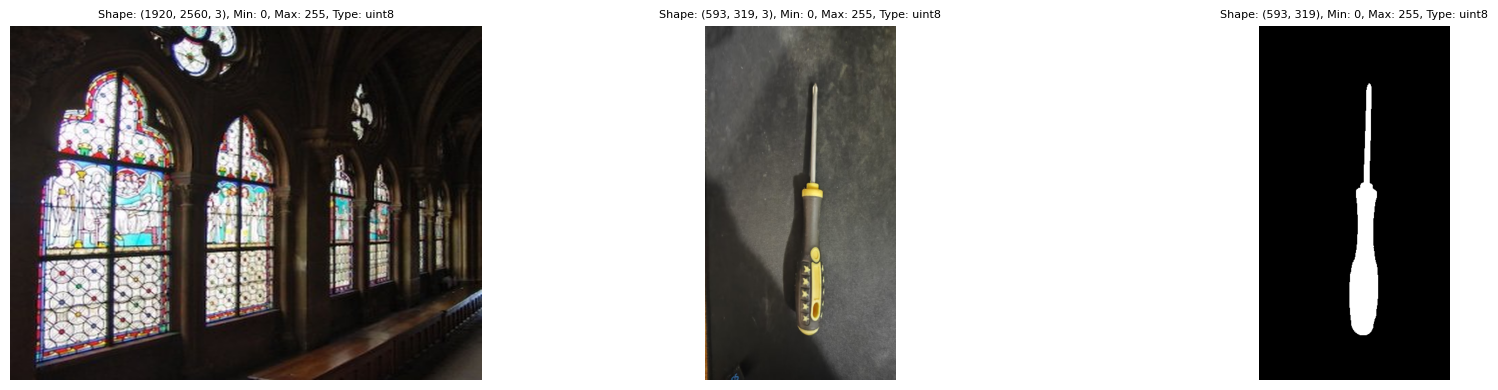

In [54]:
# Show results
show_images([dst, src, mask], figsize=(6, 4))

In [68]:
# Define the location where the center of src will be cloned onto dst
# E.g., center = (x, y) pixel coordinates in dst
x_frac = 1/2
y_frac = 1/2
# center = (int(dst.shape[1] * x_frac), int(dst.shape[0] * y_frac))
center = (1619, 159)

# Perform seamless cloning
print(f'Cloning at center {center}')
output = cv2.seamlessClone(src, dst, mask.copy(), center, cv2.NORMAL_CLONE)

Cloning at center (1619, 159)


error: OpenCV(4.11.0) /io/opencv/modules/core/src/matrix.cpp:806: error: (-215:Assertion failed) 0 <= roi.x && 0 <= roi.width && roi.x + roi.width <= m.cols && 0 <= roi.y && 0 <= roi.height && roi.y + roi.height <= m.rows in function 'Mat'


In [65]:
# Define the location where the center of src will be cloned onto dst
# E.g., center = (x, y) pixel coordinates in dst
x_frac = 2/3
y_frac = 1/2
center = (int(dst.shape[1] * x_frac), int(dst.shape[0] * y_frac))

# Perform seamless cloning
print(f'Cloning at center {center}')
output2 = cv2.seamlessClone(src, dst, mask.copy(), center, cv2.NORMAL_CLONE)

Cloning at center (1706, 960)


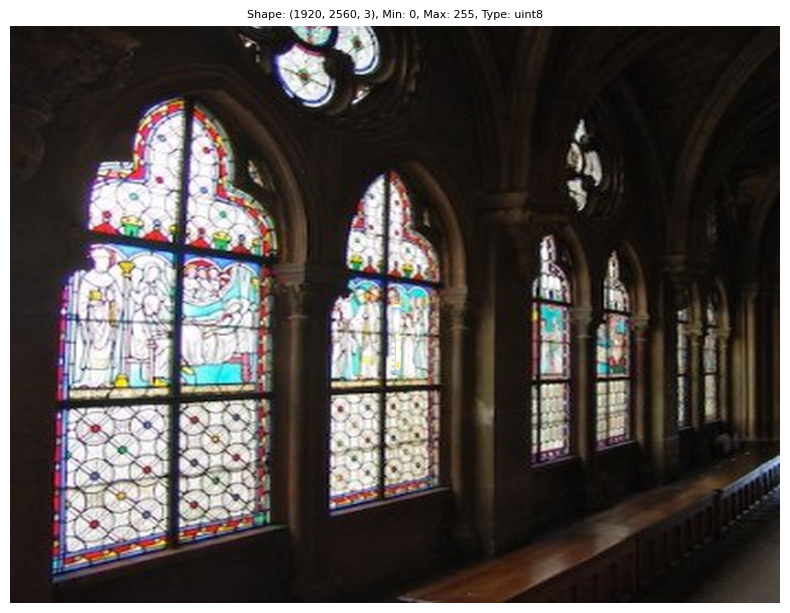

In [67]:
show_images([output], figsize=(8, 8))

# Try other stuff

In [ ]:
target_tensor = torch.load('test/target_tensor.pt')
source_tensor = torch.load('test/source_tensor.pt')
mask_tensor = torch.load('test/mask_tensor.pt')
loaded_background_array = torch.load('test/background_array.pt')
offset_adj = torch.tensor([135, 345])

In [ ]:
print(target_tensor.min(), target_tensor.max(), source_tensor.min(), source_tensor.max(), mask_tensor.min(), mask_tensor.max(), loaded_background_array.min(), loaded_background_array.max())

In [ ]:
background_array = pietorch.blend(target_tensor, source_tensor, mask_tensor, offset_adj, False, channels_dim=2)

In [ ]:
# save background_array to image
# background_array
plt.imshow(background_array.numpy())
plt.show()
plt.imshow((background_array.numpy()*255).astype(np.uint8))

In [ ]:
load_clip = np.clip(loaded_background_array, 0, 1)
print(loaded_background_array.max(), loaded_background_array.min(), loaded_background_array.shape)
print(load_clip.max(), load_clip.min(), load_clip.shape)

In [ ]:
# save background_array to image
# background_array
plt.imshow(loaded_background_array.numpy())
plt.show()
plt.imshow(load_clip.numpy())
plt.show()
plt.imshow((load_clip.numpy()*255).astype(np.uint8))
plt.show()
plt.imshow((loaded_background_array.numpy()*255).astype(np.uint8))

In [ ]:
# target_tensor = TF.to_tensor(synth_images[i]).permute(1,2,0)
# source_tensor = TF.to_tensor(foreground).permute(1,2,0)
# mask_tensor = TF.to_tensor(mask).squeeze(0) #PIL2array1C(mask)
# source_tensor, mask_tensor, offset_adj = trim_mask(target_tensor, source_tensor, mask_tensor, offset)
# offset_adj = torch.tensor(offset_adj[::-1])
# print(offset_adj)


# img_1 = Image.open('/home/data/raw/backgrounds/bg-20k/BG-20k/train/h_0a0c92d7.jpg')
# target_tensor_manual = TF.to_tensor(img_1).permute(1,2,0)

background_array = blend(target_tensor_manual, source_tensor, mask_tensor, offset_adj, False, channels_dim=2)

result = Image.fromarray((background_array.numpy()*255).astype(np.uint8), 'RGB')

In [ ]:
plt.imshow(result)

In [ ]:
background_array.min()

In [ ]:
# background_array -= background_array.min()
# background_array /= background_array.max()
plt.imshow(background_array.numpy())
plt.show()
plt.imshow(Image.fromarray((background_array.numpy()*255).astype(np.uint8), 'RGB'))
plt.show()

In [ ]:
def PIL2array1C(img):
    '''Converts a PIL image to NumPy Array

    Args: img(PIL Image): Input PIL image
    Returns: NumPy Array: Converted image
    '''
    return np.array(img.getdata(), np.uint8).reshape(img.size[1], img.size[0])

def PIL2array3C(img):
    '''Converts a PIL image to NumPy Array

    Args: img(PIL Image): Input PIL image
    Returns: NumPy Array: Converted image
    '''
    return np.array(img.getdata(), np.uint8).reshape(img.size[1], img.size[0], 3)

def show_details(img, figsize=(5,5)):
	if isinstance(img, Image.Image):
		print(f"Shape: {img.size} Min: {img.getextrema()[0]}, Max: {img.getextrema()[1]}")
	else:
		print(f"Shape: {img.shape} Min: {img.min()}, Max: {img.max()}")
	
	plt.figure(figsize=figsize)
	plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
	plt.show()

In [ ]:
bg_path = '/home/data/raw/backgrounds/indoorCVPR_09_images/dining057.jpg'
img_path = '/home/data/raw/kaggle_v0/hammer/images/a7cc2f51-40c3ae9f-1bda-4ace-896e-971d9adddd0e.jpg'
mask_path = img_path.replace('.jpg', '_mask.png').replace('.jpeg', '_mask.png').replace('/images','/masks')
label_path = img_path.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('/images','/labels')

In [ ]:
target = cv2.imread(bg_path)
source = cv2.imread(img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
print(target.shape, source.shape, mask.shape)

In [ ]:
result = pie.poisson_edit(source, target, mask, offset=(5,5))

In [ ]:

# bg_path = '/home/data/raw/backgrounds/indoorCVPR_09_images/arton447_ba6a0.jpg'
# bg_path = '/home/data/raw/backgrounds/bg-20k/BG-20k/train/h_0a0c92d7.jpg'

target = img_1
# img_1 = Image.open(bg_path)
# img_1 = img_1.resize((640*4, 480*4), Image.LANCZOS)
# target = TF.to_tensor(img_1).transpose(0,2).transpose(0,1)
# target = PIL2array3C(img_1)

# img_path = '/home/data/raw/kaggle_v0/hammer/images/0a89821a-211e2d2f-45eb-451d-9885-dfc3b07e2bf9.jpg'
# img_path = '/home/data/raw/kaggle_v0/screwdriver/images/35f643d3-f6373cbc-ab88-454f-b386-e0843be187b4.jpeg'

# source = Image.open(img_path)
# source = Image.open(img_path)
# resize source image to be smaller
scaling_factor = min(target.shape[1], target.shape[0])/max(source.shape[0], source.shape[1]) * 0.9
resized_dims = (int(source.shape[0] * scaling_factor), int(source.shape[1] * scaling_factor))
source = cv2.resize(source, resized_dims, interpolation=cv2.INTER_LANCZOS4)
# source = source.rotate(15, expand=True)
# source = TF.to_tensor(source).transpose(0,2).transpose(0,1)
# source = PIL2array3C(source)

# loaded_mask_tensor = torch.load('test/mask_tensor.pt').numpy()
# loaded_mask_img = Image.open('test/mask.jpg')
# mask_img = loaded_mask_img
# print(mask_img.min(), mask_img.max())

# mask_img = Image.fromarray(mask_img)#.convert('1')
# mask_img = Image.fromarray(255-PIL2array1C(mask_img)).convert('1')
# mask_img = mask_img.resize(resized_dims, Image.LANCZOS)
# print(mask_img.size)
# mask_img = mask_img.rotate(15, expand=True)
# print(mask_img.size)
# mask = TF.to_tensor(mask_img).squeeze(0)
# mask = (1-mask)  # Invert mask and normalize to [0, 1]
# plt.imshow(mask)


# mask_img = Image.open(mask_path)
# mask_img = Image.fromarray(255-PIL2array1C(mask_img)).convert('1')
# # xmin, ymin, xmax, ymax = read_darknet_bboxes(label_path, mask_img.size[0], mask_img.size[1])[0]
# # mask_img = mask_img.crop((xmin, ymin, xmax, ymax))
mask_img = cv2.resize(mask_img, resized_dims, interpolation=cv2.INTER_LANCZOS4)
mask = mask_img

# show_details(mask_img)

# mask_img = mask_img.rotate(15, expand=True)
# mask = TF.to_tensor(mask_img).squeeze(0)
# mask = PIL2array1C(mask_img)
# TRIMMM
# corner = torch.tensor([150,100])
corner = (150,100)

print('Blending images with shapes:', target.shape, source.shape, mask.shape)

center = (corner[0]+source.shape[0]//2, corner[1]+source.shape[1]//2)
print('Center:', center)
result = cv2.seamlessClone(source, target, 255-mask, center, cv2.NORMAL_CLONE)
# result = np.clip(pietorch.blend_wide(target, source, mask, corner, False, channels_dim=2, ), 0, 1)

In [ ]:
# show_details(loaded_mask_tensor)
show_details(target)
show_details(source)
show_details(mask)
show_details(result, figsize=(12,12))

In [ ]:
from scipy.ndimage import laplace
def poisson_blend(target_img, src_img, mask_img, iter: int = 1024):
    for _ in range(iter):
        noise = laplace(target_img - src_img)
        target_img = target_img + 0.25 * mask_img * noise
    return target_img.clip(0, 1)

In [ ]:
new_mask = np.transpose(np.array([mask,mask,mask]), (1,2,0))#.shape

In [ ]:
source = cv2.resize(source, (target.shape[1], target.shape[0]), interpolation=cv2.INTER_LANCZOS4)
mask = cv2.resize(mask, (target.shape[1], target.shape[0]), interpolation=cv2.INTER_LANCZOS4)
short_result = poisson_blend(target/255, source/255, 1-(new_mask)/255, iter=15)

In [ ]:
show_details((short_result*255).astype(np.uint8))

In [ ]:
result_conv = (result.numpy()*255).astype(np.uint8)

In [ ]:
#imshow the result image in a 12x8 inches figure
plt.figure(figsize=(12, 8))
plt.imshow(result_conv)
plt.axis('off')

In [ ]:
print(result.min(), result.max())